In [1]:
from pathlib import Path
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from typing import List
import sys


sys.path.append("../")

from src.common_functions import *

In [2]:
# sample data
RAW_DATA_PATH = "../datasets/fraud/vehicle_fraud.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem
df = pd.read_csv(RAW_DATA_PATH)
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
print(df.shape[0])
df["fraud_found_p"].value_counts()/df.shape[0]*100

pd.set_option('display.max_columns', None)

df.head()

15420


,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,policy_number,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,address_change_claim,number_of_cars,year,base_policy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [3]:
df.isna().any()

month                    False
week_of_month            False
day_of_week              False
make                     False
accident_area            False
day_of_week_claimed      False
month_claimed            False
week_of_month_claimed    False
sex                      False
marital_status           False
age                      False
fault                    False
policy_type              False
vehicle_category         False
vehicle_price            False
fraud_found_p            False
policy_number            False
rep_number               False
deductible               False
driver_rating            False
days_policy_accident     False
days_policy_claim        False
past_number_of_claims    False
age_of_vehicle           False
age_of_policy_holder     False
police_report_filed      False
witness_present          False
agent_type               False
number_of_suppliments    False
address_change_claim     False
number_of_cars           False
year                     False
base_pol

In [4]:
df.value_counts(["make", "fraud_found_p"])

make       fraud_found_p
Pontiac    0                3624
Toyota     0                2935
Honda      0                2622
Mazda      0                2231
Chevrolet  0                1587
Ford       0                 417
Accura     0                 413
VW         0                 275
Pontiac    1                 213
Toyota     1                 186
Honda      1                 179
Mazda      1                 123
Dodge      0                 107
Saab       0                  97
Chevrolet  1                  94
Mercury    0                  77
Accura     1                  59
Saturn     0                  52
Ford       1                  33
Nisson     0                  29
BMW        0                  14
Saab       1                  11
VW         1                   8
Mercury    1                   6
Jaguar     0                   6
Saturn     1                   6
Porche     0                   5
Mecedes    0                   3
Ferrari    0                   2
Dodge      1      

In [5]:
df[sorted(df.columns)].dtypes

accident_area            object
address_change_claim     object
age                       int64
age_of_policy_holder     object
age_of_vehicle           object
agent_type               object
base_policy              object
day_of_week              object
day_of_week_claimed      object
days_policy_accident     object
days_policy_claim        object
deductible                int64
driver_rating             int64
fault                    object
fraud_found_p             int64
make                     object
marital_status           object
month                    object
month_claimed            object
number_of_cars           object
number_of_suppliments    object
past_number_of_claims    object
police_report_filed      object
policy_number             int64
policy_type              object
rep_number                int64
sex                      object
vehicle_category         object
vehicle_price            object
week_of_month             int64
week_of_month_claimed     int64
witness_

In [6]:
df["fraud_found_p"].value_counts()/df.shape[0]*100

fraud_found_p
0    94.014267
1     5.985733
Name: count, dtype: float64

In [7]:
y = "fraud_found_p"

# some generic cleaning
df = df.loc[df.day_of_week_claimed!=0]
df = df.loc[df.policy_type!="Sport - Liability"]
df["vehicle_price"] = df["vehicle_price"].str.replace("less than ", "").str.replace("more than ", "").str.split(" to").str[0].astype(int)
df["past_number_of_claims"]= df["past_number_of_claims"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["days_policy_claim"] = df["days_policy_claim"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["days_policy_accident"] = df["days_policy_accident"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["age_of_vehicle"] = df["age_of_vehicle"].str.replace("new", "0").str.replace("more than ", "").str.split("").str[1].astype(int)
df["age_of_policy_holder"] = df["age_of_policy_holder"].str.replace("over ", "").str.split("").str[1:3].str.join("").astype(int)
df["address_change_claim"] = df["address_change_claim"].str.split("").str[1].str.replace("n", "0").str.replace("u", "0.25").astype(float)
df["number_of_suppliments"] = df["number_of_suppliments"].str.split("").str[1].str.replace("n", "0").str.replace("m", "5").astype(int)
df['number_of_cars'] = df.number_of_cars.str.split("").str[1].str.replace("m", "8")
df["number_of_cars_as_int"] = df["number_of_cars"].str.split("").str[1].str.replace("m", "8").astype(int)
COLUMNS_TO_DROP = ["address_change_claim", "number_of_cars", "policy_number"]
assert df[y].isna().any() == False
# drop single row with Lexus as encoder can't handle cases seen in only train, while encoding test
drop_condition = ((df.make.isin(["Lexus", "Ferrari", "Mecedes"])) | (
    df.make.isin(["BMW", "Nisson", "Mecedes", "Dodge"]) & (df[y] == 1)))
raw_features = df.drop(
    COLUMNS_TO_DROP, axis=1).loc[~drop_condition]

# ML tuning
# add make otherwise there are unknown brands in test set, and encoder can't handle
train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=raw_features[[y, "make"]])

fit_le = LabelEncoder().fit(train[y])

In [8]:
df.shape[0] - raw_features.shape[0]

11

In [9]:
# def build_column_transformer_for_df(train_x: pd.DataFrame, text_columns:List[str]) -> ColumnTransformer:
#     """Builds a column transformer for a pandas dataframe."""
#     # Get the categorical and numerical columns
#     categorical_columns = train_x.select_dtypes(
#         include='object').columns.to_list()
#     numerical_columns = train_x.select_dtypes(
#         include='number').columns.to_list()

#     num_prep = Pipeline(steps=[
#         ('num_imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler())
#     ])

#     cat_prep = Pipeline(steps=[
#         ('cat_imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OneHotEncoder(sparse_output=False))
#     ])

#     transformer = ColumnTransformer([
#         ('text', TfidfVectorizer(), text_columns),
#         ('num', num_prep, numerical_columns),
#         ('cat', cat_prep, categorical_columns)
#     ])

#     return transformer

In [10]:
# pipeline = build_sklearn_pipeline(train, y, model_name="logistic", model=LogisticRegression())
# pipeline.fit(train.drop(y, axis=1), train[y])

In [11]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': list(range(6, 32, 8)),
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

# text_columns = ["address_change_claim"]

# steps = build_column_transformer_for_df(
#     train_x=train.drop(y, axis=1))._transformers
# steps.insert(0, ('text', TfidfVectorizer(), [text_column]))
# preprocessor = ColumnTransformer(steps)

# preprocessor = build_column_transformer_for_df(train.drop(y, axis=1), text_columns)
# pipeline = build_sklearn_pipeline(
#     train, y_col_name=y, model_name=MODEL_NAME, model=model, transformer=preprocessor)
grid = sklearn_gridsearch_using_pipeline(train, y_col_name=y, model_name=MODEL_NAME,
                                  model=model, fit_le=fit_le, param_grid=param_grid, verbose=1, n_folds=5) #, pipeline=pipeline)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1440 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^

Best score: 0.7747645155518006
Best parameters: {'logistic__C': 10, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 22, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['week_of_month',
                                                   'week_of_month_claimed',
                                                   'age', 'vehicle_price',
                                                   'rep_number', 'deductible',
                                                   'driver_rating',
                                                   'days_policy_accident',
                                                   'days_policy_claim',
                                                   'past_number_of_claims',
                                                   'age_of_vehi...
                                                   'make', 'accident_area',
                                                   'day_of_week_claimed',
                                                   'month_claimed', 'sex',
                                                   'marital_status', 'fault',
                                                   'policy_type',
                                                   'vehicle_category',
                                                   'police_report_filed',
                                                   'witness_present',
                                                   'agent_type',
                                                   'base_policy'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=22)),
                ('logistic', LogisticRegression(C=10))])

In [12]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [13]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.1,0.2,6,1,l2,0.635090,0.016550
144,0.1,0.2,6,10,l2,0.629353,0.012542
288,0.1,0.2,6,100,l2,0.625187,0.012274
432,0.1,0.2,6,1000,l2,0.630578,0.013777
6,0.1,0.2,14,1,l2,0.639274,0.018766
...,...,...,...,...,...,...,...
568,0.7,1.0,22,1000,l2,0.770875,0.009224
142,0.7,1.0,30,1,l2,0.766218,0.010357
286,0.7,1.0,30,10,l2,0.759426,0.011487
430,0.7,1.0,30,100,l2,0.769202,0.007273


In [14]:
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [15]:
# To check if categorical values are in train but not in test 
categorical_columns = train.select_dtypes(
    include='object').columns.to_list()

for feature in categorical_columns:
    diff = set(train[feature]).difference(test[feature])
    if len(diff)>0:
        print(feature)

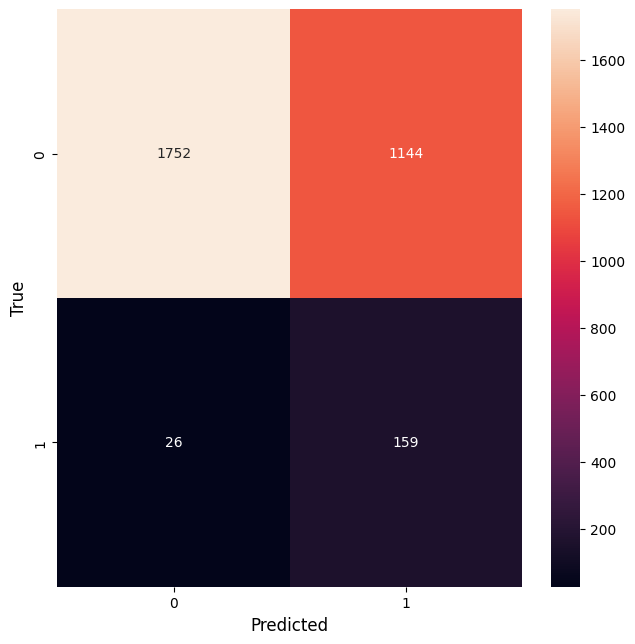

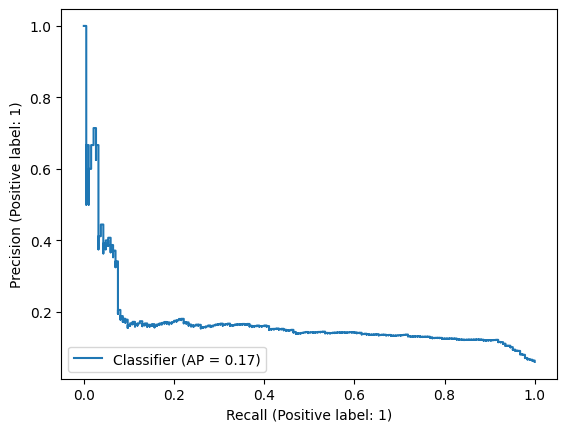

In [16]:
# one case can't get fixed, won't affect results
fixed_test_set = test.reset_index(drop=True).drop(1136, axis=0)

evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=fixed_test_set, y_col_name=y, model_name= 'logistic')

In [17]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.7811242823994626
Best parameters: {'xgb__subsample': 1.0, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 3, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 1.0, 'under__sampling_strategy': 0.2, 'pca__n_components': 30, 'over__sampling_strategy': 0.4}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['week_of_month',
                                                   'week_of_month_claimed',
                                                   'age', 'vehicle_price',
                                                   'rep_number', 'deductible',
                                                   'driver_rating',
                                                   'days_policy_accident',
                                                   'days_policy_claim',
                                                   'past_number_of_claims',
                                                   'age_of_vehi...
                               feature_types=None, gamma=0.5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [18]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

In [19]:
# one case can't get fixed, won't affect results
# fixed_test_set = test.reset_index(drop=True).drop(1136, axis=0)


evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

ValueError: Found unknown categories ['0'] in column 4 during transform

In [20]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# evaluation metrics

In [21]:
test = fixed_test_set

In [47]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a/2000

test_predictions = test.copy(deep=True)
test_predictions["y_predicted"] = best_pipeline_log_reg.predict(test_predictions.drop(y, axis=1))
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions['A'] = impute.fit_transform(
    (test["vehicle_price"].to_frame()))[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions['instance_cost'] = test_predictions.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions['instance_cost'].sum()/len(test_predictions))

Test cost/loss = 1650.
 total cost/loss average :  0.5355404089581305


In [23]:
print(test['vehicle_price'].unique())

[69000 30000 20000 40000 60000]


In [24]:
print(test["fraud_found_p"].unique())

[0 1]


In [46]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a/2000

test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["vehicle_price"].to_frame()))[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions))

Test cost/loss = 1904.
 total cost/loss average :  0.6181434599156118


# e-amc

In [54]:
cb_column = 'cb'
test[cb_column]= (test["vehicle_price"])

test['TN'] = 0
test['FN'] = -test[cb_column]/2000
test['FP'] = -1
test['TP'] = 0

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)
test_predictions_xgb = add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [51]:
test

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,cb,TN,FN,FP,TP,prob_churn,EAP,EP,y_predicted_proba,instance_cost
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,69000.0,0,34.5,1,0,0.315432,0.845442,0.059468,0.845442,0.0
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,30000.0,0,15.0,1,0,0.234852,0.682426,0.059468,0.682426,0.0
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,20000.0,0,10.0,1,0,0.008797,0.165467,0.059468,0.165467,0.0
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,30000.0,0,15.0,1,0,0.369137,0.521801,0.059468,0.521801,0.0
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,20000.0,0,10.0,1,0,0.279919,0.639805,0.059468,0.639805,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,Nov,2,Tuesday,Toyota,Urban,Wednesday,Nov,2,Male,Married,48,Policy Holder,Sedan - All Perils,Sedan,20000,1,9,400,4,30,30,1,7,41,No,No,External,0,1995,All Perils,1,20000.0,0,10.0,1,0,0.495551,3.243530,9.405322,0.675647,10.0
3054,May,4,Tuesday,Chevrolet,Urban,Friday,May,4,Male,Married,77,Policy Holder,Sedan - Collision,Sedan,20000,1,13,400,4,30,30,2,7,65,No,No,External,3,1996,Collision,1,20000.0,0,10.0,1,0,0.155602,4.418870,9.405322,0.558113,10.0
3057,Dec,2,Sunday,Mazda,Urban,Monday,Dec,2,Female,Married,33,Policy Holder,Sedan - Liability,Sport,20000,1,3,400,1,30,30,4,7,31,Yes,No,External,0,1995,Liability,1,20000.0,0,10.0,1,0,0.036718,9.082768,9.405322,0.091723,10.0
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,30000.0,0,15.0,1,0,0.483471,3.970567,14.107983,0.735296,15.0


In [55]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

-2052.14434758725
-2861.6705743955863
EAP :  -0.6660643776654496
EP :  -0.9288122604334912


In [56]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test))

-2088.5263413084467
-2861.6705743955863
EAP :  -0.6778728793600931
EP :  -0.9288122604334912


# amc metric


Decision Threshold: 0.01, Test cost/loss = 2796.00
Decision Threshold: 0.02, Test cost/loss = 2747.00
Decision Threshold: 0.03, Test cost/loss = 2736.00
Decision Threshold: 0.04, Test cost/loss = 2719.00
Decision Threshold: 0.05, Test cost/loss = 2730.50
Decision Threshold: 0.06, Test cost/loss = 2688.50
Decision Threshold: 0.07, Test cost/loss = 2636.50
Decision Threshold: 0.08, Test cost/loss = 2605.50
Decision Threshold: 0.09, Test cost/loss = 2501.50
Decision Threshold: 0.10, Test cost/loss = 2400.50
Decision Threshold: 0.11, Test cost/loss = 2277.50
Decision Threshold: 0.12, Test cost/loss = 2183.50
Decision Threshold: 0.13, Test cost/loss = 2065.50
Decision Threshold: 0.14, Test cost/loss = 1940.50
Decision Threshold: 0.15, Test cost/loss = 1873.50
Decision Threshold: 0.16, Test cost/loss = 1790.50
Decision Threshold: 0.17, Test cost/loss = 1729.50
Decision Threshold: 0.18, Test cost/loss = 1677.50
Decision Threshold: 0.19, Test cost/loss = 1653.50
Decision Threshold: 0.20, Test 

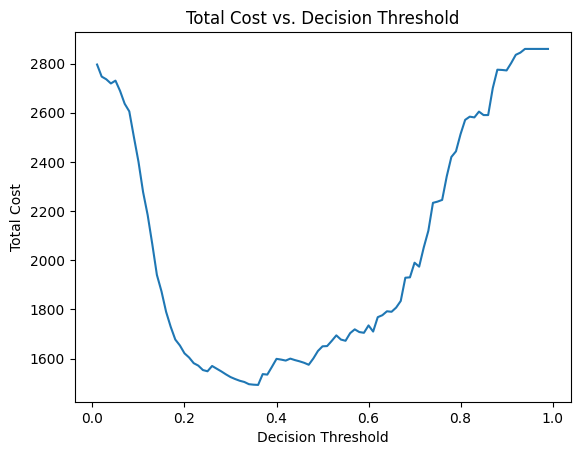

(0.36000000000000004, 0.4845829276209023, 1493.0)

In [57]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')

Decision Threshold: 0.01, Test cost/loss = 2336.50
Decision Threshold: 0.02, Test cost/loss = 1982.50
Decision Threshold: 0.03, Test cost/loss = 1810.50
Decision Threshold: 0.04, Test cost/loss = 1697.50
Decision Threshold: 0.05, Test cost/loss = 1613.50
Decision Threshold: 0.06, Test cost/loss = 1542.50
Decision Threshold: 0.07, Test cost/loss = 1499.50
Decision Threshold: 0.08, Test cost/loss = 1490.50
Decision Threshold: 0.09, Test cost/loss = 1446.50
Decision Threshold: 0.10, Test cost/loss = 1414.50
Decision Threshold: 0.11, Test cost/loss = 1430.00
Decision Threshold: 0.12, Test cost/loss = 1419.00
Decision Threshold: 0.13, Test cost/loss = 1508.50
Decision Threshold: 0.14, Test cost/loss = 1500.50
Decision Threshold: 0.15, Test cost/loss = 1500.50
Decision Threshold: 0.16, Test cost/loss = 1485.50
Decision Threshold: 0.17, Test cost/loss = 1465.50
Decision Threshold: 0.18, Test cost/loss = 1499.00
Decision Threshold: 0.19, Test cost/loss = 1565.50
Decision Threshold: 0.20, Test 

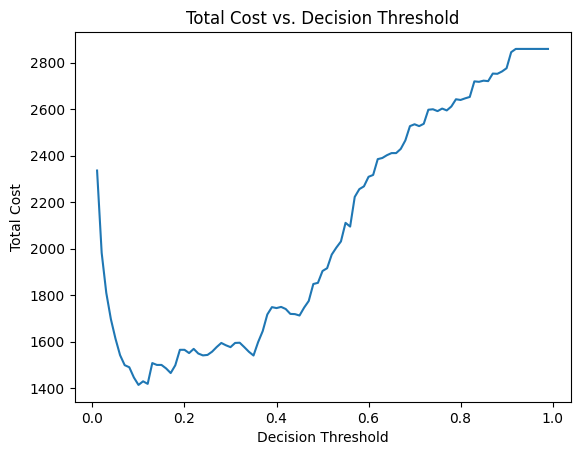

(0.09999999999999999, 0.4591041869522882, 1414.5)

In [58]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_predictions_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, 'cb')

# EMP 

In [59]:
cb_column = 'cb'
test[cb_column]= (test["vehicle_price"])

test['TN'] = 0
test['FN'] = -test[cb_column]/2000
test['FP'] = -1
test['TP'] = -1 +test[cb_column]/2000   



test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)
test_predictions_xgb = add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [ ]:
test

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,cb,TN,FN,FP,TP,prob_churn,EAP,EP,y_predicted_proba,instance_cost
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,69000.0,0,-34.5,-1,33.5,0.547337,-0.573904,-0.059468,0.573904,0.0
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,30000.0,0,-15.0,-1,14.0,0.664650,-0.474446,-0.059468,0.474446,0.0
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,20000.0,0,-10.0,-1,9.0,0.006119,-0.068604,-0.059468,0.068604,0.0
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,30000.0,0,-15.0,-1,14.0,0.329809,-0.340556,-0.059468,0.340556,0.0
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,20000.0,0,-10.0,-1,9.0,0.377317,-0.493566,-0.059468,0.493566,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,Nov,2,Tuesday,Toyota,Urban,Wednesday,Nov,2,Male,Married,48,Policy Holder,Sedan - All Perils,Sedan,20000,1,9,400,4,30,30,1,7,41,No,No,External,0,1995,All Perils,1,20000.0,0,-10.0,-1,9.0,0.446822,-0.430069,-8.870112,0.503681,10.0
3054,May,4,Tuesday,Chevrolet,Urban,Friday,May,4,Male,Married,77,Policy Holder,Sedan - Collision,Sedan,20000,1,13,400,4,30,30,2,7,65,No,No,External,3,1996,Collision,1,20000.0,0,-10.0,-1,9.0,0.169780,-4.762376,-8.870112,0.275664,10.0
3057,Dec,2,Sunday,Mazda,Urban,Monday,Dec,2,Female,Married,33,Policy Holder,Sedan - Liability,Sport,20000,1,3,400,1,30,30,4,7,31,Yes,No,External,0,1995,Liability,1,20000.0,0,-10.0,-1,9.0,0.015678,-9.147776,-8.870112,0.044854,10.0
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,30000.0,0,-15.0,-1,14.0,0.785010,-0.703049,-13.275434,0.492998,15.0


In [60]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

-348.33732593398247
-2702.6239656011685
EAP :  -0.11305982665822216
EP :  -0.8771905113927844


In [61]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test))

-872.0776101405645
-2702.6239656011685
EAP :  -0.28305018180479213
EP :  -0.8771905113927844


# MP

In [64]:
def instance_dependent_cost_2(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 1 -a/2000
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a/2000

Decision Threshold: 0.01, Test cost/loss = 121.50
Decision Threshold: 0.02, Test cost/loss = 72.50
Decision Threshold: 0.03, Test cost/loss = 61.50
Decision Threshold: 0.04, Test cost/loss = 44.50
Decision Threshold: 0.05, Test cost/loss = 89.50
Decision Threshold: 0.06, Test cost/loss = 47.50
Decision Threshold: 0.07, Test cost/loss = -4.50
Decision Threshold: 0.08, Test cost/loss = 31.50
Decision Threshold: 0.09, Test cost/loss = -72.50
Decision Threshold: 0.10, Test cost/loss = -164.50
Decision Threshold: 0.11, Test cost/loss = -287.50
Decision Threshold: 0.12, Test cost/loss = -367.50
Decision Threshold: 0.13, Test cost/loss = -476.50
Decision Threshold: 0.14, Test cost/loss = -601.50
Decision Threshold: 0.15, Test cost/loss = -645.50
Decision Threshold: 0.16, Test cost/loss = -719.50
Decision Threshold: 0.17, Test cost/loss = -766.50
Decision Threshold: 0.18, Test cost/loss = -818.50
Decision Threshold: 0.19, Test cost/loss = -819.50
Decision Threshold: 0.20, Test cost/loss = -851

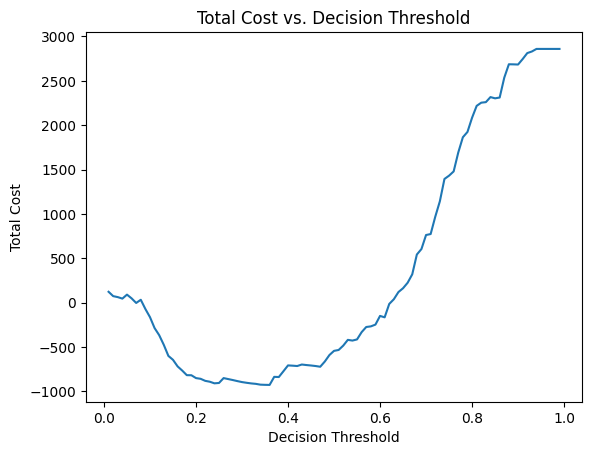

(0.36000000000000004, -0.30136319376825704, -928.5)

In [65]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')

Decision Threshold: 0.01, Test cost/loss = -159.50
Decision Threshold: 0.02, Test cost/loss = -509.50
Decision Threshold: 0.03, Test cost/loss = -702.50
Decision Threshold: 0.04, Test cost/loss = -838.50
Decision Threshold: 0.05, Test cost/loss = -889.50
Decision Threshold: 0.06, Test cost/loss = -846.50
Decision Threshold: 0.07, Test cost/loss = -871.50
Decision Threshold: 0.08, Test cost/loss = -928.50
Decision Threshold: 0.09, Test cost/loss = -859.50
Decision Threshold: 0.10, Test cost/loss = -876.50
Decision Threshold: 0.11, Test cost/loss = -783.50
Decision Threshold: 0.12, Test cost/loss = -797.50
Decision Threshold: 0.13, Test cost/loss = -748.50
Decision Threshold: 0.14, Test cost/loss = -775.50
Decision Threshold: 0.15, Test cost/loss = -716.50
Decision Threshold: 0.16, Test cost/loss = -747.50
Decision Threshold: 0.17, Test cost/loss = -729.50
Decision Threshold: 0.18, Test cost/loss = -756.50
Decision Threshold: 0.19, Test cost/loss = -723.50
Decision Threshold: 0.20, Test 

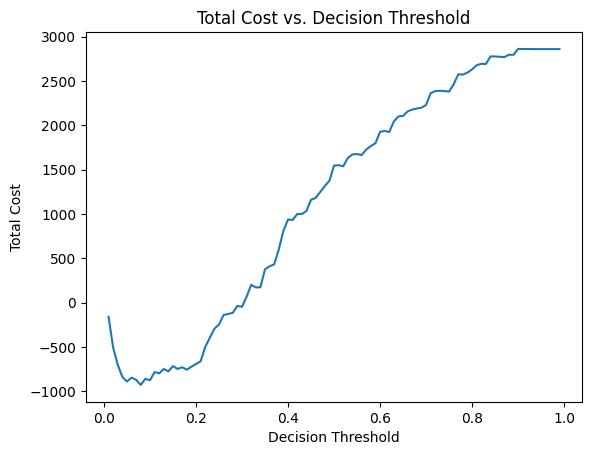

(0.08, -0.30136319376825704, -928.5)

In [ ]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_predictions_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, 'cb')